# Topic Modelling on VOEB 1948-1973

VOEB = Vereinigung Österreichischer Bibliotheken (Communications/Mitteilungen)

Try to construct a time series with generated topic models from scanned volumes

In [4]:
# quick extraction from transkribus export (conducted locally)
# this will render an error, since data file is absent

import zipfile
from pprint import pprint
from pathlib import Path
# datadir = Path('data-voeb')
datadir = Path("data")
datafile = datadir.joinpath('export_job_1689308.zip')
if datafile.is_file():
    with zipfile.ZipFile(datafile) as myzip:
        namelist = myzip.namelist()
        # pprint(namelist)
        candidates = []
        for f in namelist:
            if f[7:].find('/') > -1:
                continue
            if f.endswith(".txt") or f.endswith(".xml"):
                candidates.append(f)
        pprint(candidates)
        for c in candidates:
            filename = c.split("/")[-1]
            with open(datadir.joinpath(filename), 'wb') as outf:
                outf.write(myzip.read(c))

## Data preparation and sectioning (into years / vols)

This was done by manually inspecting each source file and inserting division markers like
`#### 1966-04 .3` (`.3` as volume number)

In [5]:
import re
import sys
import datetime
from pprint import pprint
from pathlib import Path

# some libraries issue deprecation warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


import gensim
import pandas as pd
import matplotlib.pyplot as plt
sys.path = ["/scratch/"] + sys.path #  tm_utils.py reside in `/scratch` directory
import tm_utils                     #  but we import it from current dir

# mapping for splitter and dividing into years, vols...
DATASRC = Path("data-tw-src")
DATA = Path("data-tw")
mapping = {}
corpusname = "voeb48-73"
datasette = False #  Do not save into datasette database
print("imports done")

imports done


In [6]:
number_re = re.compile(r'\s+\d+\s+') # remove numbers from text
# #### 1973-03 .1
split_re = re.compile(r'\#\#\#\# (?P<year>\d{4})-(?P<month>\d{2}) *\.*(?P<vol>\S*)')
files = DATASRC.glob("*.txt")

df = pd.DataFrame()
data = []
headers = ['year', 'month', 'vol', 'text', 'filename']
for idx, f in enumerate(sorted(files)):
    tmp = []
    filename = f.stem
    # print(filename)
    cont = f.read_text()
    first = True
    for m in split_re.finditer(cont):
        span = m.span()
        if first:
            prev_end = span[1]
        this_start = span[0]
        if not first:
            text = cont[prev_end:this_start]
            prev_end = span[1]
            tmp = [year, month, vol, text, filename]
            data.append(tmp)
        month = m.group('month')
        year = m.group('year')
        vol = m.group('vol')
        # print(year, month, span)
        first = False      
    data.append([year, month, vol, cont[prev_end:], filename])
print(f"processed {idx+1} files from {DATASRC} into {len(data)} volumes")
df = pd.DataFrame(data, columns=headers)    
df.to_csv(str(DATA.joinpath("voeb_48-73.csv")), sep=";", quoting=2, index=False)    
print(datetime.datetime.now().isoformat())


processed 27 files from data-tw-src into 112 volumes
2021-10-29T15:46:28.789662


## Lemmata, Corpus, Dictionary

In [7]:
data_words = []
documents = [x[3] for x in data]
for text in documents:
    data_words.append(list(
            gensim.utils.simple_preprocess(
                text, deacc=True, min_len=5)
        ))
print(data_words[0][:20])
add_stopword = ["bibliothekar", "bibliothekare",
               "bibliothek", "bibliotheken"]
data_words = tm_utils.remove_stopwords(data_words, include=add_stopword)

# bigrams:

data_words_bigrams, data_words_trigrams = tm_utils.make_bi_trigrams(data_words)


['scnftfalen', 'vereinigung', 'bibliothekare', 'herausgegeben', 'auftrage', 'vorstandes', 'vereinigung', 'bibliothekare', 'vereinigung', 'bibliothe', 'sommer', 'sommer', 'genaues', 'verzeichnis', 'artikel', 'mitteilungen', 'jahres', 'mitteilungen', 'witteilungen', 'seilagen']


In [8]:
# lemmatization
corpusname = "voeb48-73"
data_lemmatized = tm_utils.lemmatization(data_words_bigrams)
save_lemmatized = tm_utils.save_lemmatized(data_lemmatized, corpusname=corpusname,
                                           datadir=DATA)
# cnotify("Lemmatization done")
print("done")

done


In [9]:
idword, dictionary = tm_utils.get_corpus_dictionary(data_lemmatized, 
                        corpusname=corpusname, save=True, 
                        datadir=DATA, from_file=False)



data-tw/dict_voeb48-73_20211029-154628.dict
saved dictionary and corpus in MarketMatrix format


computing coherence for the model starting with 8, interval 2 and stopping at 30
computing lda num topics of 8
computing lda num topics of 10
computing lda num topics of 12
computing lda num topics of 14
computing lda num topics of 16
computing lda num topics of 18
computing lda num topics of 20
computing lda num topics of 22
computing lda num topics of 24
computing lda num topics of 26
computing lda num topics of 28


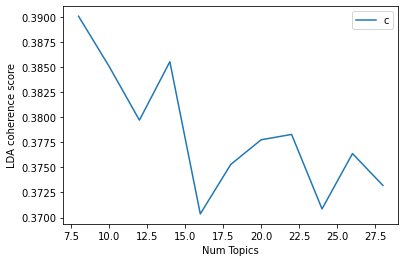

topics: 8 coherence:  0.39008303975333114
topics: 10 coherence:  0.38510483609474594
topics: 12 coherence:  0.37971670339959324
topics: 14 coherence:  0.38554514200014817
topics: 16 coherence:  0.37036066498440806
topics: 18 coherence:  0.37529464387039135
topics: 20 coherence:  0.37775907219201404
topics: 22 coherence:  0.3782917153376321
topics: 24 coherence:  0.37085971741257806
topics: 26 coherence:  0.3763805143792078
topics: 28 coherence:  0.3732050638274837
=== 8
=== 10
=== 12
=== 14
=== 16
=== 18
=== 20
=== 22
=== 24
=== 26
=== 28
CPU times: user 1min 12s, sys: 5.58 s, total: 1min 18s
Wall time: 31.8 s


In [10]:
%%time
tm_utils.compute_coherence(dictionary, idword, data_lemmatized, corpusname=corpusname, datadir=DATA,
                          stop=30, step=2)
# takes about 30 secs for 112 documents
# optimal topic no = 12


### Plotting and visualizing

In [11]:
import datetime
# Plotting tools
import pyLDAvis
try:
    import pyLDAvis.gensim  # don't skip this
except ImportError:
    import pyLDAvis.gensim_models as gensimvis
    
import matplotlib.pyplot as plt
%matplotlib inline

NOWSTR = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


#continue
lda_model = gensim.models.ldamodel.LdaModel(corpus=dictionary,
                                           id2word=idword,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=False,
                                           minimum_probability=0.01,
                                           # distributed=True
                                           )
lda_model.save(str(DATA.joinpath("{}_lda_single.model".format(corpusname))))
# pprint(lda_model.print_topics())
savelda = str(DATA.joinpath("saved_lda_{}_{}.json".format(corpusname, NOWSTR)))
visu = gensimvis.prepare(lda_model, dictionary, idword, mds='mmds')
pyLDAvis.save_json(visu, savelda)
pyLDAvis.save_html(visu, str(DATA.joinpath("saved_lda_{}_{}.html".format(corpusname, NOWSTR))))
pyLDAvis.display(visu)

### Now for the tables



In [12]:
from operator import itemgetter
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # cf. `testing_103.ipynb`
    sent_topics_df = pd.DataFrame()
    topics = {}
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        # row_item = row[0]
        row_item = row[0] if ldamodel.per_word_topics else row 
        # print(row_item)
        try:            
            row_item = sorted(row_item, key=itemgetter(1), reverse=True)[0]
        except:
            print(row_item, row)
            continue
        topic_num, prop_topic = row_item
        if not topic_num in topics:
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            topics[topic_num] = topic_keywords
        else:
            topic_keywords = topics[topic_num]
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), 
                                    str(topic_num)+": " + topic_keywords]), ignore_index=True)
 
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    sent_topics_df['Dominant_Topic'] = sent_topics_df['Dominant_Topic'].fillna(0).apply(lambda x: str(int(x)))
    return(sent_topics_df)


In [13]:
# what topic a given document is about
data_lemmatized = tm_utils.get_lemmatized(corpusname=corpusname, datadir=DATA)
id2word, corpus = tm_utils.get_corpus_dictionary(data_lemmatized, 
                        corpusname=corpusname, save=False, 
                        datadir=DATA, from_file=True)

# above:
lda_model = gensim.models.LdaModel.load(str(DATA.joinpath("{}_lda_single.model".format(corpusname))))
# watch out: data is source data, not lemmatized data!
raw_df = pd.read_csv(DATA.joinpath("voeb_48-73.csv"), sep=";")
data = raw_df['text'].to_list()

# we should create a column with the date/vol in it (also necessary for timeline)

df_topic_sent_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)
print(df_topic_sent_keywords.columns)
df_topic_sent_keywords['Dominant_Topic'] = df_topic_sent_keywords['Dominant_Topic'].fillna(0).apply(lambda x: str(int(x)))
# Format
df_dominant_topic = df_topic_sent_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

corpusname: voeb48-73_
voeb48-73_20211029-154628 voeb48-73
loading dict and corpus from data-tw/dict_voeb48-73_20211029-154628.dict, data-tw/corpus_voeb48-73_20211029-154628.mm
Index(['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 0], dtype='object')


Document_No Dominant_Topic  Topic_Perc_Contrib  \
0            0              7              0.4622   
1            1              7              0.9389   
2            2              7              0.9316   
3            3              2              0.9992   
4            4              2              0.7848   
5            5              2              0.9982   
6            6              7              0.8136   
7            7              2              0.4115   
8            8              7              0.9400   
9            9              7              0.9379   

                                            Keywords  \
0  7: osterr, titel, vereinigung, mitteilungen, d...   
1  7: osterr, titel, vereinigung, mitteilungen, d...   
2  7: osterr, titel, vereinigung, mitteilungen, d...   
3  2: vereinigung, osterr, mitglieder, vorsitzend...   
4  2: vereinigung, osterr, mitglieder, vorsitzend...   
5  2: vereinigung, osterr, mitglieder, vorsitzend...   
6  7: osterr, titel, vereinigung, mitteilungen, d...   
7  2: vereinigung, osterr, mitglieder, vorsitzend...   
8  7: osterr, titel, vereinigung, mitteilungen, d...   
9  7: osterr, titel, vereinigung, mitteilungen, d...   

                                                Text  
0  \nScnftfalen\n\n\ne,/.\ndei  3et\n\nARBEITSPRO...  
1  \nMITTEILUNGEN\nDER VEREINIGUNG ÖSTERREICHISCH...  
2  \nMITTEILUNGEN\nDER VEREINIGUNG ÖSTERREICHISCH...  
3  \n\nMITTEILUNGEN\nDER VEREINIGUNG ÖSTERREICHIS...  
4  \n\nMITTEILUNGEN\nDER VEREINIGUNG ÖSTERREICHIS...  
5  \nJegjet\n\n\nARBEITSPROTOKOLL\nder\nVereinigu...  
6  \n\n\nVereinigung\nWien, am 19.XI.1949.\nOeste...  
7  \n\nVereinigung\nWien, am 20.XII.1949.\nOester...  
8  \n\n_MITTEILUNGEN_\n\n\nDER VEREINIGUNG ÖSTERR...  
9  \n\n_MITTEILUNGEN_\n\n\nDER VEREINIGUNG ÖSTERR...

In [14]:
output_table = "voeb_48-73_dominant_topics"
output_csv = str(DATA.joinpath(f"{output_table}.csv"))
df_dominant_topic.to_csv(output_csv, sep=";", index=False)
if datasette:
    tm_utils.csv_to_datasette(tablename=output_table, csv=output_csv, db=None)
print("saved.")

saved.


## Most representative documents for a topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [15]:
# Display setting to show more characters in column
# pd.options.display.max_colwidth = 100

most_repr = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sent_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    # print(i, len(grp))
    most_repr = pd.concat([most_repr, grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
most_repr.reset_index(inplace=True, drop=True)
# Format
most_repr.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]


output_table = "{}_most_representative_topics".format(corpusname)
output_csv = str(DATA.joinpath(output_table + ".csv"))
most_repr.to_csv(output_csv, sep=";", index=False)
if datasette:
    tm_utils.csv_to_datasette(tablename=output_table, csv=output_csv, db=None)


In [16]:
most_repr.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        10              0.9248   
1        11              0.9324   
2         2              0.9992   
3         4              0.9822   
4         5              0.9473   
5         7              0.9400   
6         9              0.9981   

                                            Keywords  \
0  10: vereinigung, osterr, prasident, fuhrung, b...   
1  11: zahlen, statistik, einheiten, mitglieder, ...   
2  2: vereinigung, osterr, mitglieder, vorsitzend...   
3  4: vereinigung, sitzung, bibliothekartag, gebe...   
4  5: kommission, kommissionen, hoheren, stattfin...   
5  7: osterr, titel, vereinigung, mitteilungen, d...   
6  9: gattin, sitzung, vereinigung, personen, wis...   

                                 Representative Text  
0  \nMITTEILUNGEN\nDER VEREINIGUNG ÖSTERREICHISCH...  
1  \nMITTEILUNGEN\nDER VEREINIGUNG ÖSTERREICHISCH...  
2  \n\nMITTEILUNGEN\nDER VEREINIGUNG ÖSTERREICHIS...  
3  \nMII TLILUNGEN\nDER VEREINIGUNG ÖSTERREICHISC...  
4  \nMITTLILUNGEN\nDER VEREINIGUNG ÖSTERREICHISCH...  
5  \n\n_MITTEILUNGEN_\n\n\nDER VEREINIGUNG ÖSTERR...  
6  \nMITTEILUNGEN\nDER VEREINIGUNG OSTERREICHISCH...

## Topic distribution across documents


Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [18]:
# Number of Documents for Each Topic
topic_counts = df_topic_sent_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

sort_keys= topic_contribution.to_dict().keys()
# Topic Number and Keywords
topic_num_keywords = df_topic_sent_keywords[['Dominant_Topic', 'Topic_Keywords']]
topic_num_keywords = topic_num_keywords.drop_duplicates()
tnk_d = topic_num_keywords.to_dict('list')
tnk = []
tnk_d_dt = tnk_d['Dominant_Topic']
tnk_d_tk = tnk_d['Topic_Keywords']
tnks = []
for idx, i in enumerate(sort_keys):
    key_idx = tnk_d_dt.index(i)
    tnk.append([i, tnk_d_tk[key_idx], topic_counts[i], topic_contribution[i]])
    tnks.append(tnk_d_tk[key_idx])

# Concatenate Column wise
df_dominant_topics = pd.DataFrame(tnk, columns=['Dominant_Topic', 'Topic_Keywords', 'Num_Documents' , 'Perc_Documents'])

output_table = "{}_distribution_of_topics".format(corpusname)
output_csv = str(DATA.joinpath(output_table + ".csv"))
df_dominant_topics.to_csv(output_csv, sep=";", index=False)
if datasette:
    tm_utils.csv_to_datasette(tablename=output_table, csv=output_csv, db=None)
# Show
df_dominant_topics

Dominant_Topic                                     Topic_Keywords  \
0              2  2: vereinigung, osterr, mitglieder, vorsitzend...   
1              7  7: osterr, titel, vereinigung, mitteilungen, d...   
2              4  4: vereinigung, sitzung, bibliothekartag, gebe...   
3              9  9: gattin, sitzung, vereinigung, personen, wis...   
4             11  11: zahlen, statistik, einheiten, mitglieder, ...   
5             10  10: vereinigung, osterr, prasident, fuhrung, b...   
6              5  5: kommission, kommissionen, hoheren, stattfin...   

   Num_Documents  Perc_Documents  
0             51          0.4554  
1             27          0.2411  
2             11          0.0982  
3              8          0.0714  
4              8          0.0714  
5              5          0.0446  
6              2          0.0179

## Time series (years, months/vols)

Have to re-read src df/csv

for each document we need the topic distribution (i.e. percentage of each topic for this doc)

this should be in model data; good to have a function doing this.

we did this for anno material (newspapers) -- but it was mallet-generated, i.e. for every
 document there is a list of topic contribution percentages (not for gensim generated ones)
 
ok, there is one for gensim, too, but gensim throws away those topics below `minimum_probability=0.01` (default)

 

In [19]:
data_lemmatized = tm_utils.get_lemmatized(corpusname=corpusname, datadir=DATA)
id2word, corpus = tm_utils.get_corpus_dictionary(data_lemmatized, 
                        corpusname=corpusname, save=False, 
                        datadir=DATA, from_file=True)
mallet_binary="/usr/local/bin/mallet-2.0.8/bin/mallet"
# lda_model = gensim.models.wrappers.LdaMallet(mallet_binary, corpus=corpus, num_topics=20, id2word=id2word,
# prefix=str(DATA.joinpath("./models/").resolve()))

# above:
# lda_model = gensim.models.LdaModel.load(str(DATA.joinpath("{}_lda_single.model".format(corpusname))))
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=30,
                                           alpha='auto',
                                           per_word_topics=False,
                                           minimum_probability=0.001,
                                           # distributed=True
                                           )

# watch out: data is source data, not lemmatized data!


corpusname: voeb48-73_
voeb48-73_20211029-154628 voeb48-73
loading dict and corpus from data-tw/dict_voeb48-73_20211029-154628.dict, data-tw/corpus_voeb48-73_20211029-154628.mm


making `gensim` generated data work for time series

In [20]:
raw_df = pd.read_csv(DATA.joinpath("voeb_48-73.csv"), sep=";")
print(raw_df.shape)
topic_no = 12
# print(lda_model.show_topics(topic_no))
topics = {}
topic_headers = []
trow_templ = [0 for x in range(topic_no)]
print(trow_templ)
# collect topic words
for t in lda_model.show_topics(num_topics=topic_no, num_words=10, log=False, formatted=False):
    tnum = t[0]
    tl = t[1]
    topics[tnum] = ", ".join([word for word, prop in tl])
    topic_headers.append(f"topic_{tnum}")
#create an array for use in time series
data = []
for i, row in enumerate(lda_model[corpus]):
    # the format of each row representing a document is:
    # 1) list of topic numbers with percentage of contributing to document
    # output: index year-month topic0 topic2 topic3... topic11
    values = trow_templ[:]
    #if i > 4:
    #    break
    year = raw_df.loc[i]['year']
    month = raw_df.loc[i]['month']
    vol = raw_df.loc[i]['vol']
    topic_values = {}
    # print(len(row))
    for r in row:
        topic_idx, val = r
        values[topic_idx] = val
    #print(row, year, month, vol)
    #print(      values)
    data.append([year, month, vol] + values)
    #print("\n")
df = pd.DataFrame(data, columns=["year", 'month', "vol"] + topic_headers)
timeseries = f"{corpusname}_time.csv"
df.to_csv(DATA.joinpath(timeseries), sep=";", index=False)


(112, 5)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


   year  month  vol  topic_0  topic_1   topic_2  topic_3   topic_4  topic_5  \
0  1948      6   ap      0.0        0  0.998196      0.0  0.001684      0.0   
1  1949     11  NaN      0.0        0  0.112218      0.0  0.033929      0.0   
2  1949     12  NaN      0.0        0  0.411546      0.0  0.000000      0.0   
3  1950      2    1      0.0        0  0.000000      0.0  0.030463      0.0   
4  1950      2    1      0.0        0  0.000000      0.0  0.029583      0.0   

   topic_6   topic_7  topic_8   topic_9  topic_10  topic_11  
0      0.0  0.000000      0.0  0.000000  0.000000       0.0  
1      0.0  0.813633      0.0  0.008988  0.031097       0.0  
2      0.0  0.335958      0.0  0.025048  0.226654       0.0  
3      0.0  0.938944      0.0  0.024035  0.006416       0.0  
4      0.0  0.939977      0.0  0.022640  0.007660       0.0  
12 Topics
col: 3 topic:  0 maxval: 0.2328647226095199
xval: 61 for topic 0 (max: 0.2328647226095199)
col: 4 topic:  1 maxval: 0
xval: None for topic 1 (m

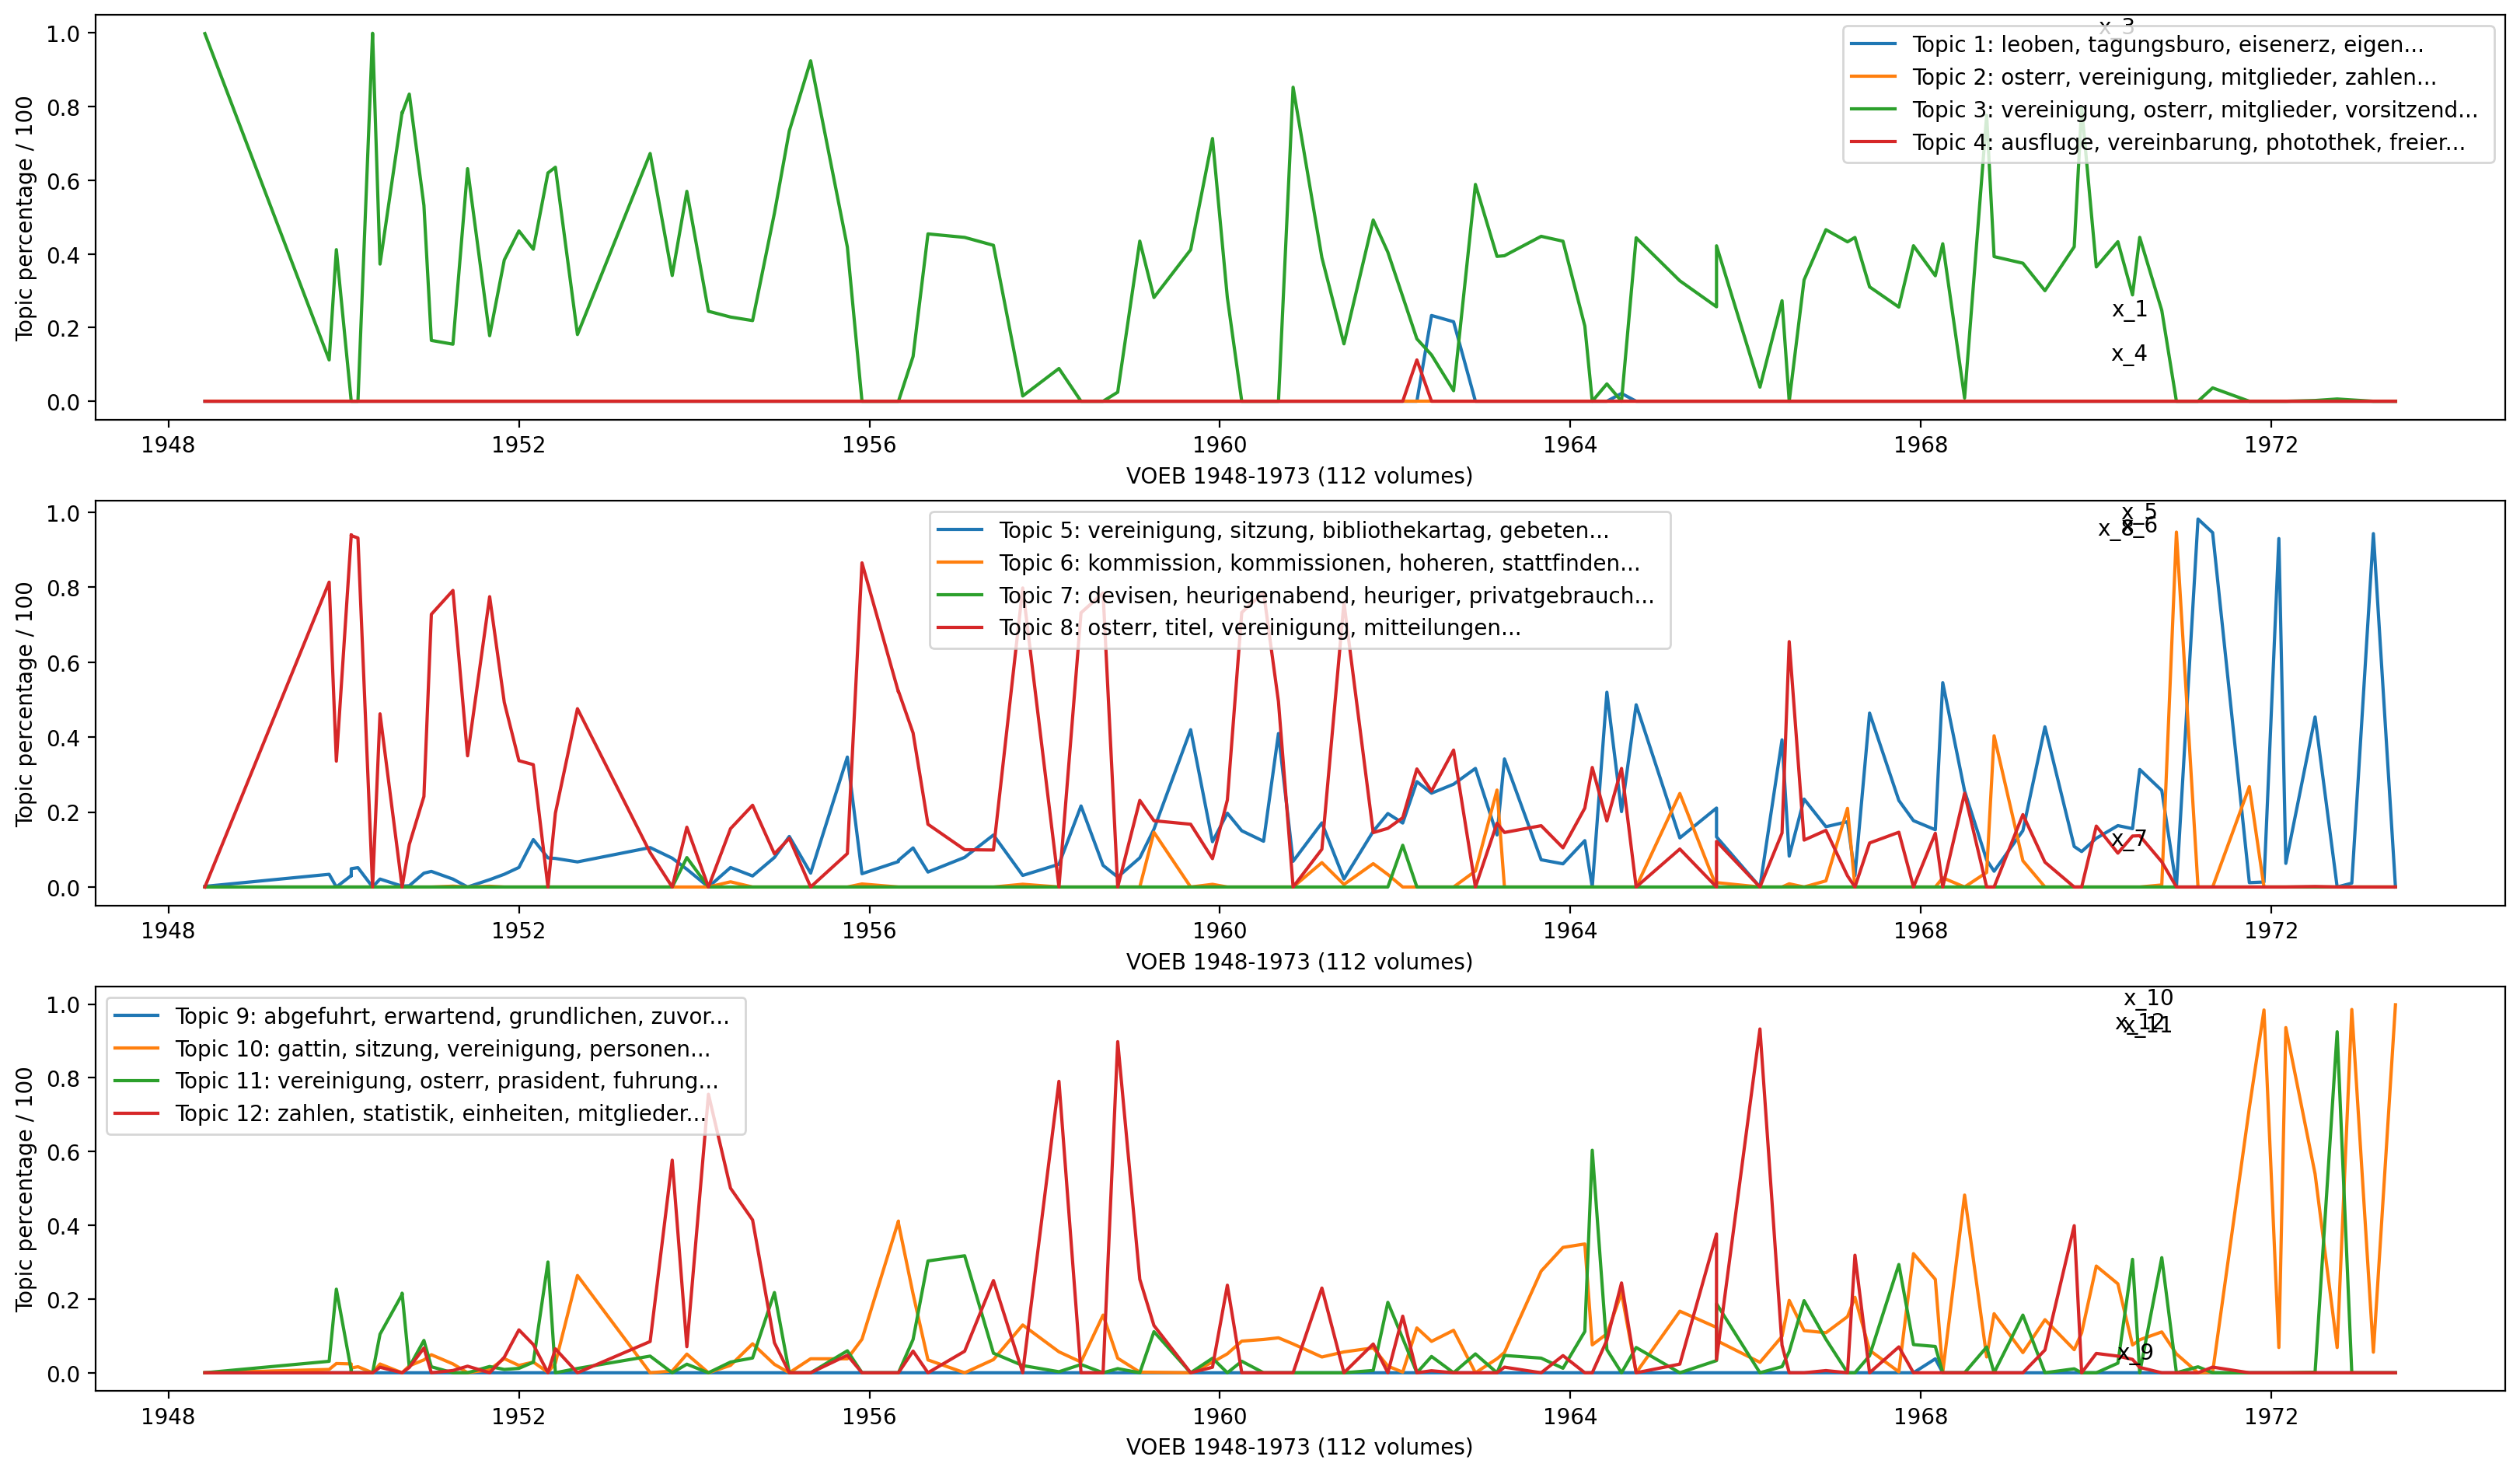

/opt/tljh/user/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/tljh/user/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/tljh/user/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/tljh/user/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/tljh/user/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in fav

In [21]:
timeseries = f"{corpusname}_time.csv"

data = pd.read_csv(DATA.joinpath(timeseries), sep=";")
data = data.sort_values(by=["year", "month", "vol"], ignore_index=True) #  sorting 
data = data.reset_index(drop=True)
print(data.head())
imgdir = DATA.joinpath("images")
imgdir.mkdir(exist_ok=True)
x = range(0, data.shape[0])
data['publ'] = data['year'].fillna("").apply(lambda x: str(x))
data['year_month'] = pd.to_datetime(data['year'].map(str) + "-" + data['month'].map(str)) 
#data['year'].fillna(0).apply(lambda x: 
#                            pd.to_datetime(df['birth_date'](x))
# data['publ'] = data['publ'].str.cat(data[['month']], sep='-', na_rep="")
x = list(data['year_month'])
# y = data
chunksize = 4
print(len(topics), "Topics")
variant = ""
plt.figure(figsize=[20,20], dpi=200)
for j in range(0, int(len(topics)/chunksize)):
    plt.subplot(511+j)
    for i in range(0, chunksize):
        col = i + chunksize * j
        col_topic_idx = col + 3
        maxval = max(data.iloc[:, col_topic_idx])
        print("col:", col_topic_idx, "topic: ", col, "maxval:", maxval)
        if maxval:
            xval = data.loc[data[f'topic_{col}'] == maxval].index.item()
        else:
            xval = None
        print("xval: {} for topic {} (max: {})".format(xval, col, maxval))
        descr = ", ".join(topics[col].split(", ")[:4])
        src = ""
        label="Topic {}: {}... {}".format(col+1, descr, src)
        if xval:
            plt.annotate("x_{}".format(col + 1), (int(xval), maxval)) #  annotate max value for topic    
        plt.plot(x, data.iloc[:, col_topic_idx], label=label)
        plt.legend()
    plt.xlabel("VOEB 1948-{} ({} volumes)".format(year, data.shape[0]))
    plt.ylabel("Topic percentage / 100")
    # plt.xlim(-18, 700)
plt.autoscale(enable=True, axis="x")
plt.savefig(str(imgdir.joinpath("voeb_{}_topics_{}_1-20.png".format(year, variant))) )
plt.show()